Andrey_Bondarchuk_stepik_id_346032105

https://colab.research.google.com/drive/1VP2A5qmn3LMTNHFz5saJNP3YQ_jY_5Ml?usp=sharing

In [ ]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 346 kB 61.4 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
     |████████████████████████████████| 596 kB 67.2 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.8 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
     |████████████████████████████████| 212 kB 81.6 MB/s 
     |████████████████████████████████| 140 kB 79.2 MB/s 
     |████████████████████████████████| 127 kB 72.9 MB/s 
     |████████████████████████████████| 144 kB 76.3 MB/s 
     |████████████████████████████████| 271 kB 73.6 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 112 kB 78.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 r

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
import warnings
#warnings.filterwarnings('ignore')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [ ]:
tokenizer.eos_token

'<|endoftext|>'

In [ ]:
tokenizer.eos_token_id

50256

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output =  self.tokenizer.encode_plus(
           text, 
           max_length = self.max_length, # максимальная длина текста 
           padding = "max_length", # надо ли добавлять паддинг в конце?
           return_tensors="pt", # возвращает pytorch тензоры
        )
        target = self.label2num[label]
        tokenizer_output.update({'labels': torch.tensor(target, dtype=torch.long)})
        return tokenizer_output

        # return {
        #     "input_ids": tokenizer_output['input_ids'], 
        #     "mask": tokenizer_output['attention_mask'],
        #     "target": target
        # }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.)
MAX_LENGTH = 128

In [ ]:
train_dataset = TweetDataset('train', emotion_dataset, tokenizer, MAX_LENGTH)
valid_dataset = TweetDataset('validation', emotion_dataset, tokenizer, MAX_LENGTH) # validation
test_dataset = TweetDataset('test', emotion_dataset, tokenizer, MAX_LENGTH)

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#next(iter(train_loader))

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

### distilgpt2

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8,
    return_dict = True
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [ ]:
model_0

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

Подготовь оптимайзер и критерий:

In [ ]:
LEARNING_RATE = 1e-5 

optimizer = torch.optim.AdamW(model_0.parameters(), lr = LEARNING_RATE) 
criterion = nn.CrossEntropyLoss() #ignore_index = tokenizer.eos_token_id)  tokenizer.eos_token
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

https://huggingface.co/docs/transformers/v4.19.2/en/model_doc/gpt2#transformers.GPT2ForSequenceClassification

**INPUT**

- **input_ids (torch.LongTensor of shape (batch_size, input_ids_length)) — input_ids_length = sequence_length if past_key_values is None else past_key_values[0][0].shape[-2] (sequence_length of input past key value states). Indices of input sequence tokens in the vocabulary.
If past_key_values is used, only input_ids that do not have their past calculated should be passed as input_ids.**

Indices can be obtained using GPT2Tokenizer. See PreTrainedTokenizer.encode() and PreTrainedTokenizer.call() for details.

What are input IDs?

- past_key_values (Tuple[Tuple[torch.Tensor]] of length config.n_layers) — Contains precomputed hidden-states (key and values in the attention blocks) as computed by the model (see past_key_values output below). Can be used to speed up sequential decoding. The input_ids which have their past given to this model should not be passed as input_ids as they have already been computed.
- **attention_mask (torch.FloatTensor of shape (batch_size, sequence_length), optional) — Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:
1 for tokens that are not masked,
0 for tokens that are masked.**

- return_dict (bool, optional) — Whether or not to return a ModelOutput instead of a plain tuple.
labels (torch.LongTensor of shape (batch_size,), optional) - Labels for computing the sequence classification/regression loss. Indices should be in [0, ..., config.num_labels - 1]. If config.num_labels == 1 a regression loss is computed (Mean-Square loss), If config.num_labels > 1 a classification loss is computed (Cross-Entropy).

- **labels (torch.LongTensor of shape (batch_size,), optional) — Labels for computing the sequence classification/regression loss. Indices should be in [0, ..., config.num_labels - 1]. If config.num_labels == 1 a regression loss is computed (Mean-Square loss), If config.num_labels > 1 a classification loss is computed (Cross-Entropy).**

**OUTPUT**

A transformers.modeling_outputs.SequenceClassifierOutputWithPast or a tuple of torch.FloatTensor (if return_dict=False is passed or when config.return_dict=False) comprising various elements depending on the configuration (GPT2Config) and inputs.

- **loss (torch.FloatTensor of shape (1,), optional, returned when labels is provided) — Classification (or regression if config.num_labels==1)**.

- **logits (torch.FloatTensor of shape (batch_size, config.num_labels)) — Classification (or regression if config.num_labels==1) scores (before SoftMax)**.

- past_key_values (tuple(tuple(torch.FloatTensor)), optional, returned when use_cache=True is passed or when config.use_cache=True) — Tuple of tuple(torch.FloatTensor) of length config.n_layers, with each tuple having 2 tensors of shape (batch_size, num_heads, sequence_length, embed_size_per_head))

Contains pre-computed hidden-states (key and values in the self-attention blocks) that can be used (see past_key_values input) to speed up sequential decoding.

- hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) — Tuple of torch.FloatTensor (one for the output of the embeddings, if the model has an embedding layer, + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).

Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.

- attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) — Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).

Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

In [ ]:
tokens = train_dataset[0]['input_ids']    # Получи токены из датасета
attention_mask = train_dataset[0]['attention_mask'] # Получи маску из датасета

outputs = model_0(input_ids = tokens.to(device), attention_mask = attention_mask.to(device)) # Посмотри на аутпут

In [ ]:
outputs.logits

tensor([[ 0.6400, -0.4459,  0.2184,  0.6053, -0.3006, -0.1490,  0.3104, -0.0739]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [ ]:
type(outputs)

transformers.modeling_outputs.SequenceClassifierOutputWithPast

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
%%time

from tqdm.notebook import tqdm

num_epochs = 15

train_history = []
valid_history = []
valid_acc_history = []
train_acc_history = []

# Train loop
for e in range(num_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(e + 1, num_epochs))
    # print('Training...')
    # ----------------------------------- train --------------------------------

    model_0.train()
    
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model_0(input_ids = input_ids, attention_mask = attention_mask, labels=labels)
        logits = outputs.logits
        past_key_values = outputs.logits
        loss = outputs.loss
        train_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model_0.parameters(), 1.0)
        optimizer.step()

        predictions_labels = logits.argmax(axis=-1).flatten()
        train_acc += (labels == predictions_labels).cpu().numpy().mean()
 
        logits.cpu()
        past_key_values.cpu()
        del logits
        del past_key_values
        torch.cuda.empty_cache()

    train_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_acc/len(train_loader)) 
 

    # ----------------------------------- valid --------------------------------
    best_valid_loss = float('inf')       
    
    valid_loss = 0
    valid_acc = 0
    model_0.eval()

    with torch.no_grad():
        for batch in valid_loader:

            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask = batch['attention_mask'].squeeze(1).to(device)
            labels = batch['labels'].to(device)

            outputs = model_0(input_ids = input_ids, attention_mask = attention_mask, labels=labels)
            logits = outputs.logits
            past_key_values = outputs.logits
            loss = outputs.loss
            valid_loss += loss.item()
         
            predictions_labels = logits.argmax(axis=-1).flatten()
            valid_acc += (labels == predictions_labels).cpu().numpy().mean()

            logits.cpu()
            past_key_values.cpu()
            del logits
            del past_key_values
            torch.cuda.empty_cache()

    valid_history.append(valid_loss/len(valid_loader)) 
    valid_acc_history.append(valid_acc/len(valid_loader)) 

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_0.state_dict(), 'best-val-GPT2ForSequenceClassification_0.pt')
 
    print(f"Train Loss: {round(train_loss / len(train_loader),4)}, "
          f"Valid Loss: {round(valid_loss / len(valid_loader),4)}, "
          f"Valid Acc: {round(valid_acc / len(valid_loader),4)}")
    if e%3 == 0:
        torch.save(model_0.state_dict(), 'GPT2ForSequenceClassification_0.pt')


======== Epoch 1 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.565, Valid Loss: 1.416, Valid Acc: 0.4512

======== Epoch 2 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.2546, Valid Loss: 1.0623, Valid Acc: 0.6143

======== Epoch 3 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.9087, Valid Loss: 0.8747, Valid Acc: 0.6865

======== Epoch 4 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6657, Valid Loss: 0.7114, Valid Acc: 0.7485

======== Epoch 5 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4862, Valid Loss: 0.5766, Valid Acc: 0.8057

======== Epoch 6 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3498, Valid Loss: 0.5042, Valid Acc: 0.8379

======== Epoch 7 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2535, Valid Loss: 0.4242, Valid Acc: 0.8711

======== Epoch 8 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1862, Valid Loss: 0.4016, Valid Acc: 0.8784

======== Epoch 9 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1481, Valid Loss: 0.4289, Valid Acc: 0.874

======== Epoch 10 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1137, Valid Loss: 0.4436, Valid Acc: 0.8755

======== Epoch 11 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1021, Valid Loss: 0.4633, Valid Acc: 0.8911

======== Epoch 12 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0861, Valid Loss: 0.4067, Valid Acc: 0.8975

======== Epoch 13 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0756, Valid Loss: 0.4479, Valid Acc: 0.897

======== Epoch 14 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0711, Valid Loss: 0.4323, Valid Acc: 0.8965

======== Epoch 15 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.061, Valid Loss: 0.4578, Valid Acc: 0.8994
CPU times: user 29min, sys: 6min 57s, total: 35min 57s
Wall time: 1h 24min 47s


In [ ]:
torch.save(model_0.state_dict(), 'GPT2ForSequenceClassification_0.pt')

In [ ]:
def plot_history(train_history, valid_history, train_acc_history, valid_acc_history):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    clear_output(True)

    ax[0].plot(train_acc_history, label='train')
    ax[0].set_xlabel('Epoch')
    ax[0].plot(valid_acc_history, label='valid')
    ax[0].set_title('accuracy')
  
    ax[1].plot(train_history, label='train')
    ax[1].set_xlabel('Epoch')
    ax[1].plot(valid_history, label='valid')
    ax[1].set_title('loss')

    plt.legend()
            
    plt.show()

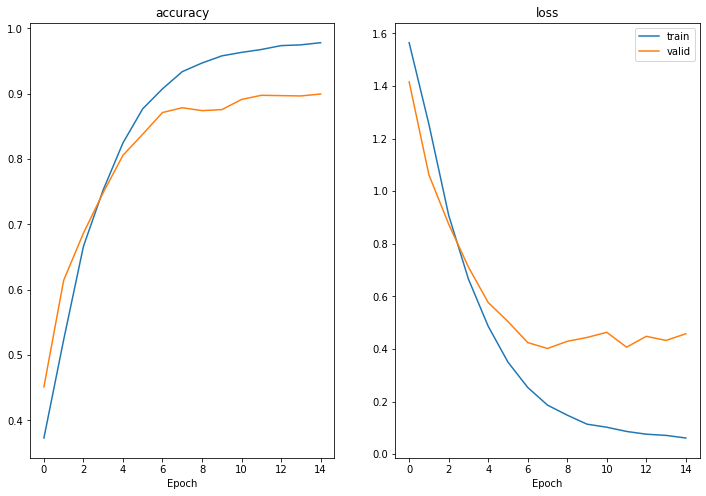

In [ ]:
plot_history(train_history, valid_history, train_acc_history, valid_acc_history)

In [ ]:
model_0.load_state_dict(torch.load('best-val-GPT2ForSequenceClassification_0.pt'))

<All keys matched successfully>

In [ ]:
# ---------------------------Testing -------------------------------------------
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)
          
        outputs = model_0(input_ids = input_ids, attention_mask = attention_mask, labels=labels)
        logits = outputs.logits
         
        predictions_labels = logits.argmax(axis=-1).flatten()
        test_acc += (labels == predictions_labels).cpu().numpy().mean()

        logits.cpu()
        del logits
        torch.cuda.empty_cache()

print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.90087890625


### Точность модели

Получена точность 0.90

После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn), seq

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Выберем предложение

In [ ]:
text = emotion_dataset["test"]["text"][5] # Выбери текст из датасета
text

'i cant walk into a shop anywhere where i do not feel uncomfortable'

In [ ]:
label =  emotion_dataset["test"]["label"][5]
label

4

In [ ]:
attns.shape

(6, 12, 13, 13)

В качестве примерв рассмотрим матрицу внимания для последнего слоя и головы 0 

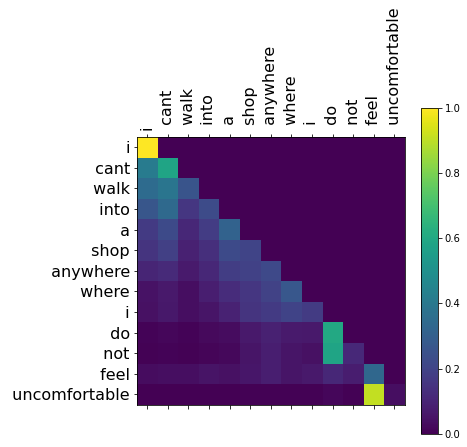

In [ ]:
attns, seq = get_attention_matrixes(model_0, tokenizer, text)
show_attention(seq, attns[-1][0])

### Карты внимания для 1, 4 и 6 слоев по всем 12 головам.

In [ ]:
def show_all_head_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    for head in range(1,13):
        ax = fig.add_subplot(4, 3, head)
        cax = ax.matshow(attentions[head-1])
        #fig.colorbar(cax)   

        # Set up axes
        ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
        ax.set_yticklabels(['']+seq, fontsize=16)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

1- й слой

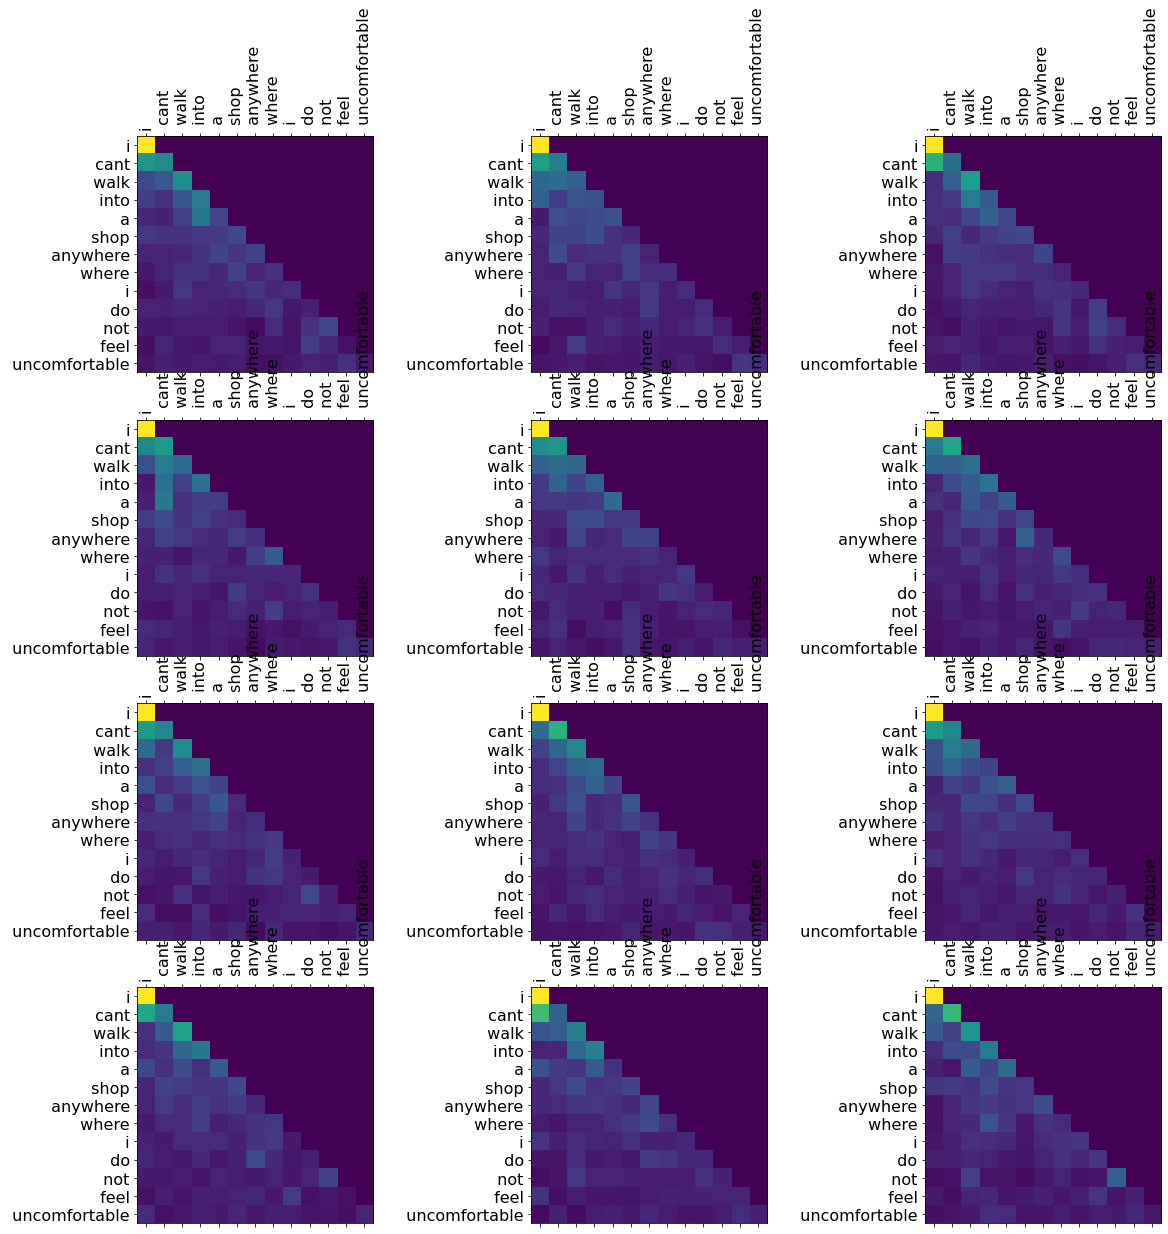

In [ ]:
show_all_head_attention(seq, attns[0])

Внимание на первом слове, далее на самом себе и равномерно убывает от токена влево.

4 - й слой

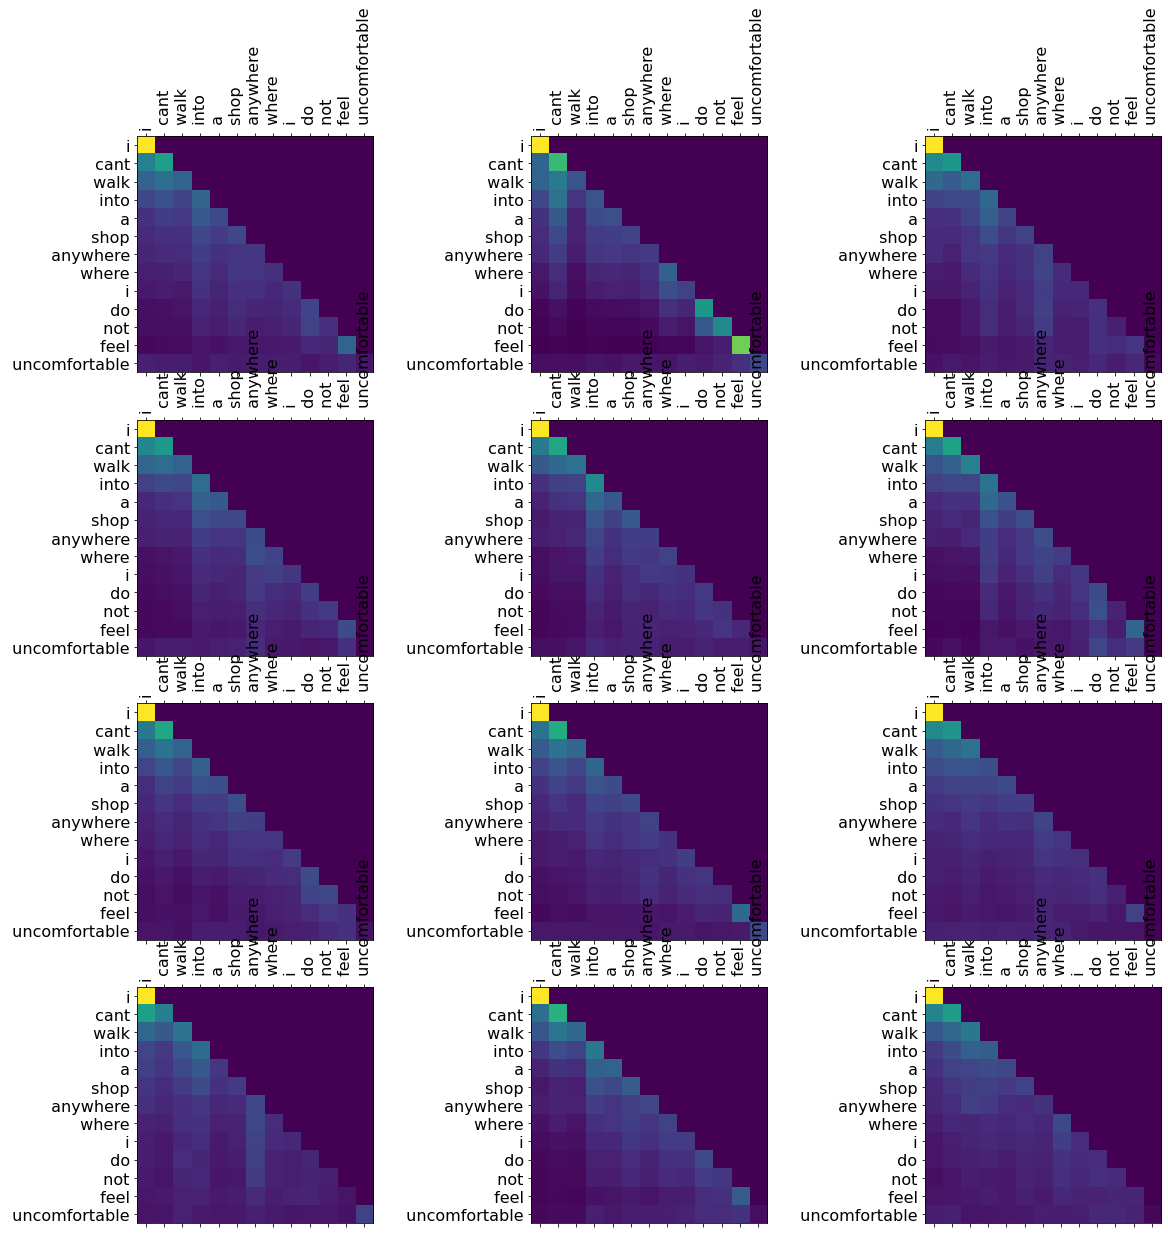

In [ ]:
show_all_head_attention(seq, attns[3])

6 - слой

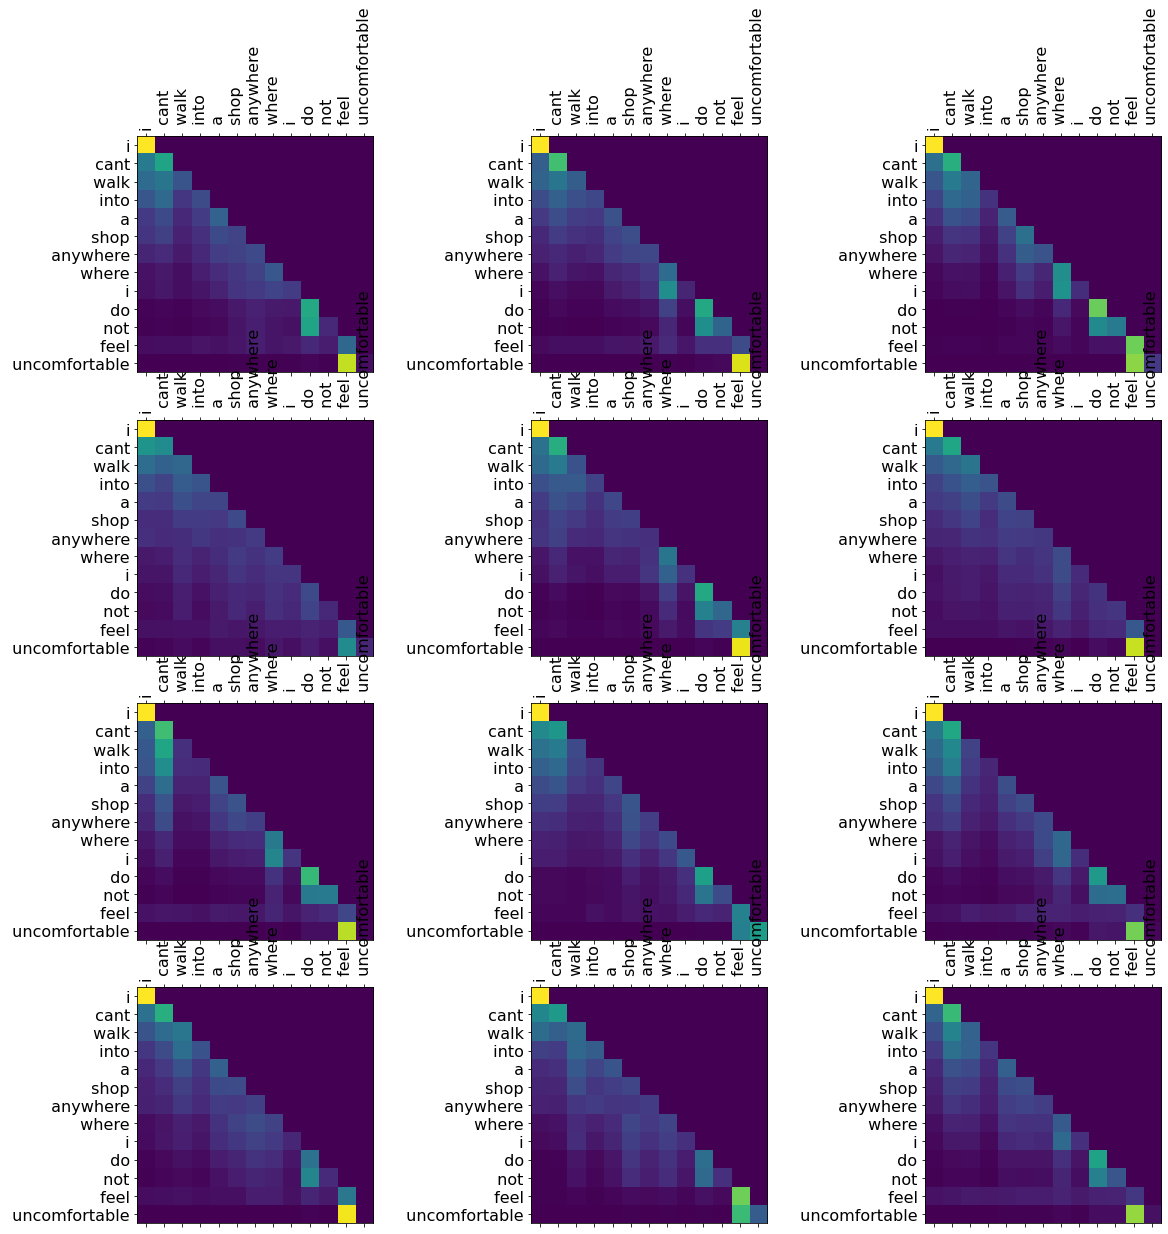

In [ ]:
show_all_head_attention(seq, attns[5])

### Выводы по модели distilgpt2

- Получена точность 0.90

для предложения *i cant walk into a shop anywhere where i do not feel uncomfortable* разобраны карты внимания

- Мы видим, что к последнему слою внимание сосредотачивается на первом и последнем слове. То есть 'I' и 'uncomfortable'. Ранее внимание по токенам было сосредоточено на самом себе и равномерно убывало к началу предложения.




## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

### distilgpt2 pretrained

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
LEARNING_RATE = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.AdamW(model_1.parameters(), lr=LEARNING_RATE) #3e-5)
criterion = nn.CrossEntropyLoss() #ignore_index = tokenizer.eos_token_id)  tokenizer.eos_token
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
%%time

num_epochs = 15

train_history = []
valid_history = []
valid_acc_history = []
train_acc_history = []

# Train loop
for e in range(num_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(e + 1, num_epochs))
    # print('Training...')
    # ----------------------------------- train --------------------------------

    model_1.train()
    
    train_loss = 0
    train_acc = 0
    for batch in tqdm(train_loader):
        
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model_1(input_ids = input_ids, attention_mask = attention_mask, labels=labels)
        logits = outputs.logits
        past_key_values = outputs.logits
        loss = outputs.loss
        train_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model_1.parameters(), 1.0)
        optimizer.step()

        predictions_labels = logits.argmax(axis=-1).flatten()
        train_acc += (labels == predictions_labels).cpu().numpy().mean()

        logits.cpu()
        past_key_values.cpu()
        del logits
        del past_key_values
        torch.cuda.empty_cache()

    train_history.append(train_loss/len(train_loader)) 
    train_acc_history.append(train_acc/len(train_loader))    

    # ----------------------------------- valid --------------------------------
    best_valid_loss = float('inf')       
    
    valid_loss = 0
    valid_acc = 0
    model_1.eval()

    with torch.no_grad():
        for batch in valid_loader:

            input_ids = batch['input_ids'].squeeze(1).to(device)
            attention_mask = batch['attention_mask'].squeeze(1).to(device)
            labels = batch['labels'].to(device)

            outputs = model_1(input_ids = input_ids, attention_mask = attention_mask, labels=labels)
            logits = outputs.logits
            past_key_values = outputs.logits
            loss = outputs.loss
            valid_loss += loss.item()
         
            predictions_labels = logits.argmax(axis=-1).flatten()
            valid_acc += (labels == predictions_labels).cpu().numpy().mean()

            logits.cpu()
            past_key_values.cpu()
            del logits
            del past_key_values
            torch.cuda.empty_cache()

    valid_history.append(valid_loss/len(valid_loader)) 
    valid_acc_history.append(valid_acc/len(valid_loader)) 

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_1.state_dict(), 'best-val-GPT2ForSequenceClassification_1.pt')
 
    print(f"Train Loss: {round(train_loss / len(train_loader),4)}, "
          f"Valid Loss: {round(valid_loss / len(valid_loader),4)}, "
          f"Valid Acc: {round(valid_acc / len(valid_loader),4)}")
    
    if e%3 == 0:
        torch.save(model_1.state_dict(), 'GPT2ForSequenceClassification_1.pt') 


======== Epoch 1 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.4751, Valid Loss: 0.8423, Valid Acc: 0.6968

======== Epoch 2 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6179, Valid Loss: 0.3366, Valid Acc: 0.8818

======== Epoch 3 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3373, Valid Loss: 0.2365, Valid Acc: 0.9106

======== Epoch 4 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2432, Valid Loss: 0.2156, Valid Acc: 0.9199

======== Epoch 5 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1926, Valid Loss: 0.1771, Valid Acc: 0.9277

======== Epoch 6 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1707, Valid Loss: 0.1745, Valid Acc: 0.9272

======== Epoch 7 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1434, Valid Loss: 0.1561, Valid Acc: 0.9331

======== Epoch 8 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1334, Valid Loss: 0.1535, Valid Acc: 0.9312

======== Epoch 9 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1248, Valid Loss: 0.1506, Valid Acc: 0.9351

======== Epoch 10 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1164, Valid Loss: 0.1443, Valid Acc: 0.937

======== Epoch 11 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1077, Valid Loss: 0.1468, Valid Acc: 0.9395

======== Epoch 12 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0983, Valid Loss: 0.1622, Valid Acc: 0.9346

======== Epoch 13 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0985, Valid Loss: 0.1531, Valid Acc: 0.9341

======== Epoch 14 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0889, Valid Loss: 0.1499, Valid Acc: 0.939

======== Epoch 15 / 15 ========


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0877, Valid Loss: 0.1445, Valid Acc: 0.9395
CPU times: user 29min 4s, sys: 7min 21s, total: 36min 25s
Wall time: 1h 22min 57s


In [ ]:
torch.save(model_1.state_dict(), 'GPT2ForSequenceClassification_1.pt')

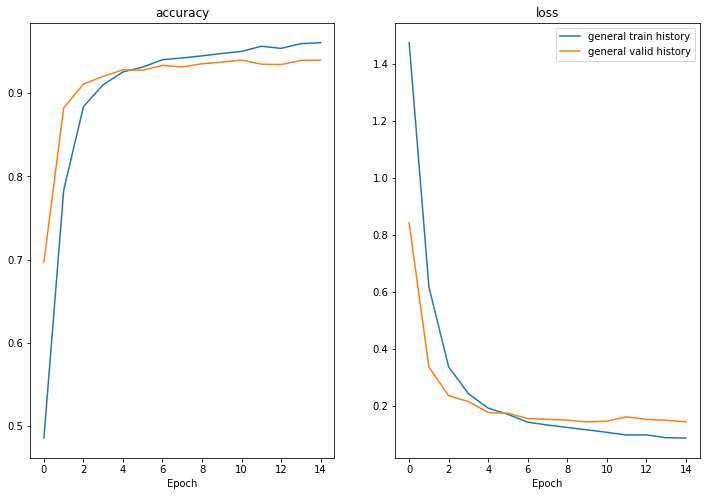

In [ ]:
plot_history(train_history, valid_history,train_acc_history, valid_acc_history)

In [ ]:
model_1.load_state_dict(torch.load('best-val-GPT2ForSequenceClassification_1.pt'))

<All keys matched successfully>

In [ ]:
# ---------------------------Testing -------------------------------------------
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].squeeze(1).to(device)
        labels = batch['labels'].to(device)
          
        outputs = model_1(input_ids = input_ids, attention_mask = attention_mask, labels=labels)
        
        logits = outputs.logits
         
        predictions_labels = logits.argmax(axis=-1).flatten()
        test_acc += (labels == predictions_labels).cpu().numpy().mean()

        logits.cpu()
        del logits
        torch.cuda.empty_cache()

print(f"Test Acc: {test_acc / len(test_loader)}")

Test Acc: 0.9248046875


### Точность модели

Получена точность 0.92. Виден прирост качества модели, по сравнению с непредобученным distilgpt2.

Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = emotion_dataset["test"]["text"][5] # Выбери текст из датасета
text

'i cant walk into a shop anywhere where i do not feel uncomfortable'

In [ ]:
tokens = tokenizer.tokenize(text)

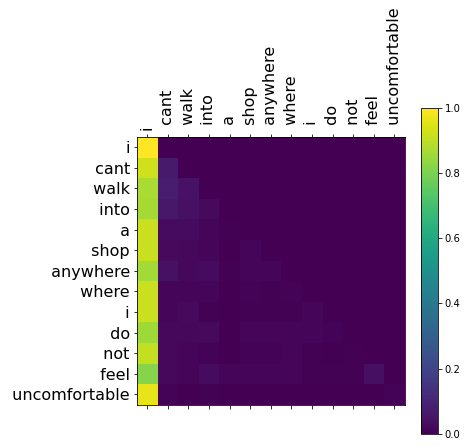

In [ ]:
attns, seq = get_attention_matrixes(model_1, tokenizer, text)
show_attention(seq, attns[-1][0])

### Карты внимания для 1, 4 и 6 слоев по всем 12 головам.

1 - й слой

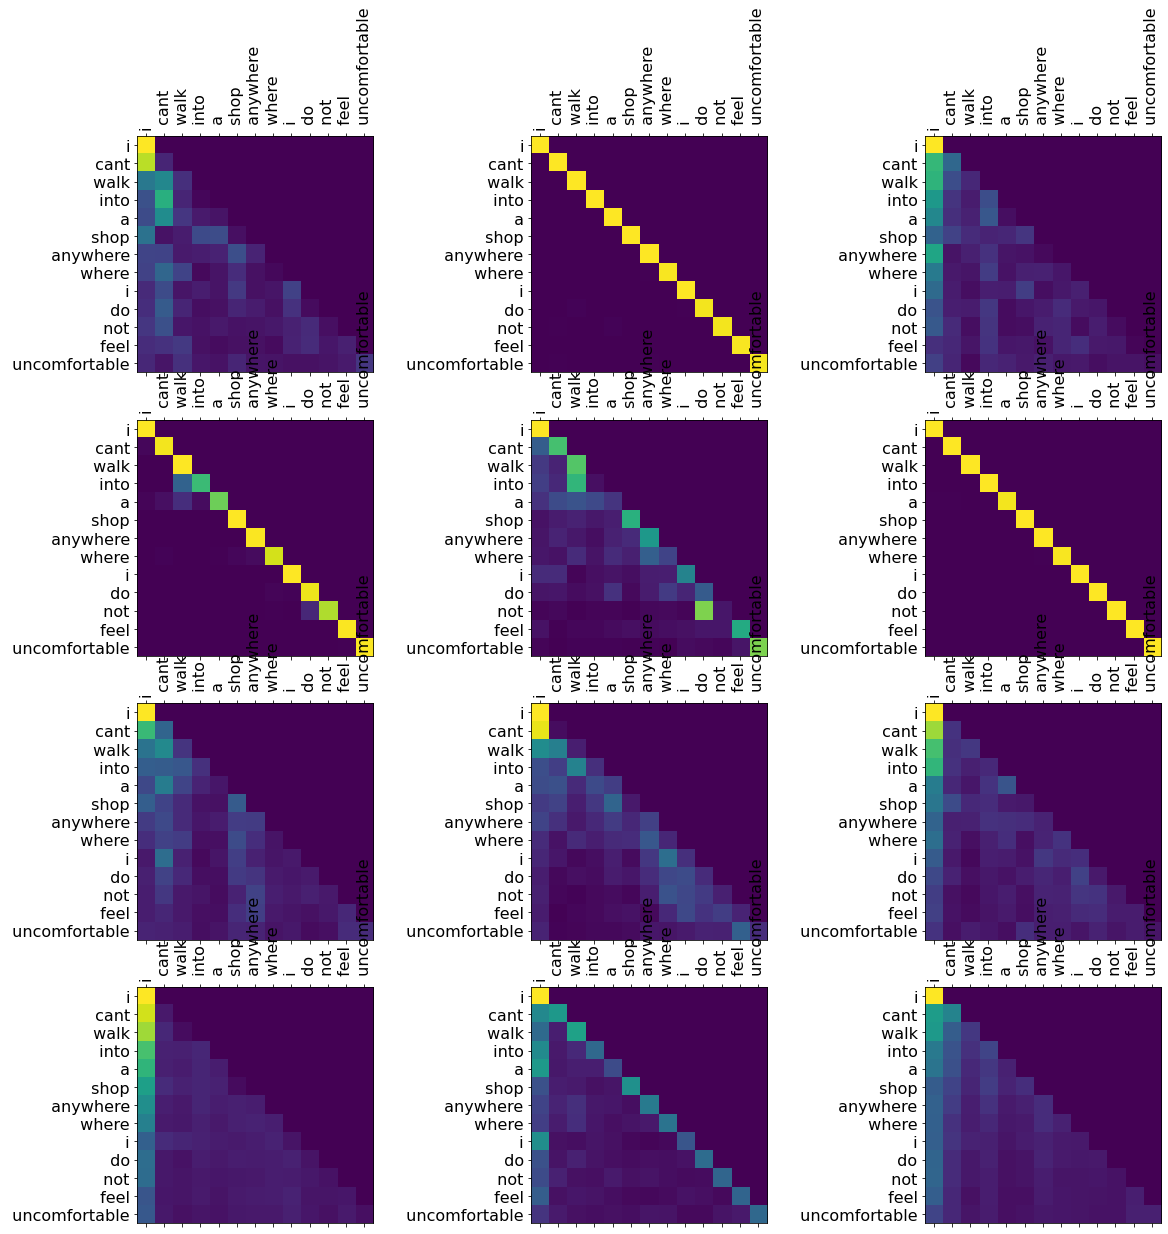

In [ ]:
show_all_head_attention(seq, attns[0])

4 - й слой

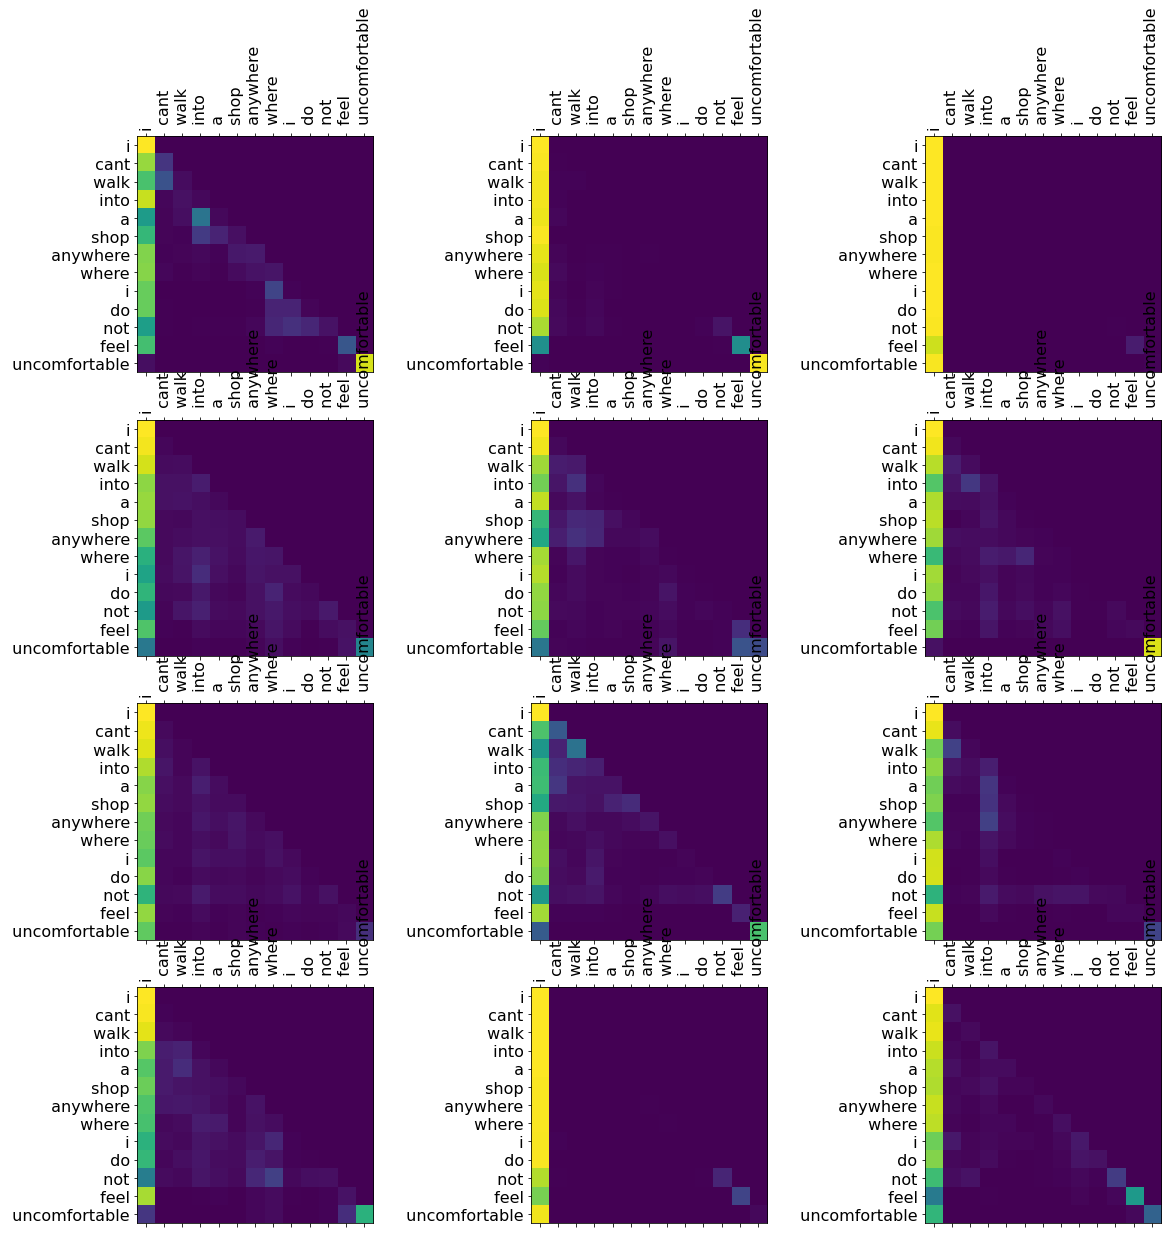

In [ ]:
show_all_head_attention(seq, attns[3])

6 - й слой

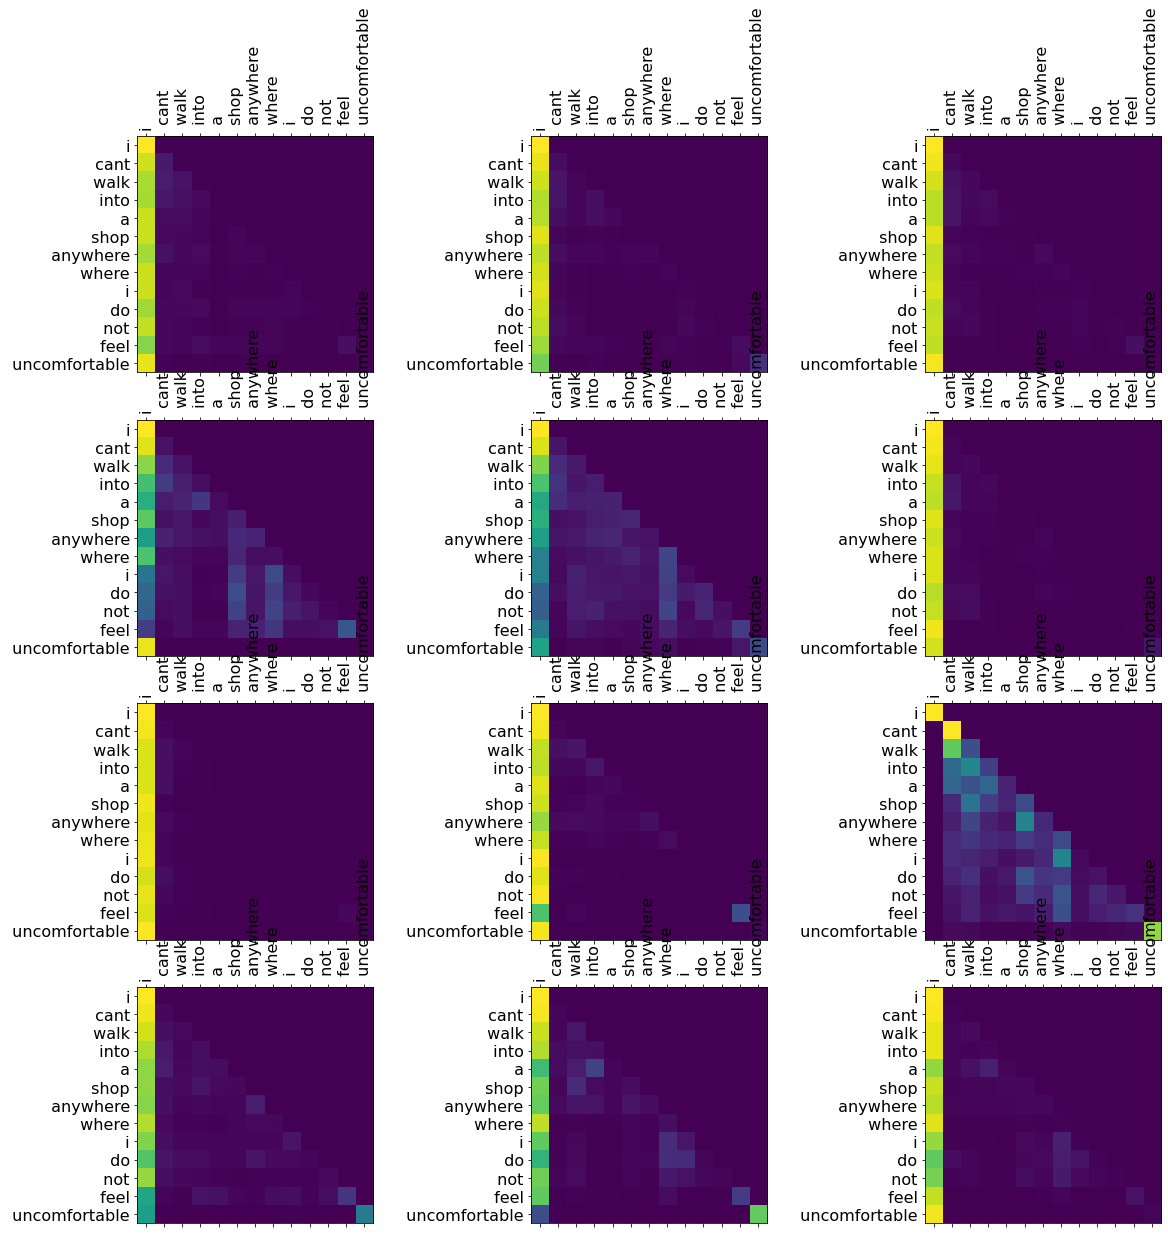

In [ ]:
show_all_head_attention(seq, attns[5])

### Выводы по модели distilgpt2 pretrained

- Получена точность 0.93

для предложения i cant walk into a shop anywhere where i do not feel uncomfortable разобраны карты внимания

- Мы видим, что только к последнему слою внимание начинает сосредотачиваться на последнем слове 'uncomfortable'. В основном же внимание сосредоточено на первом слове 'I' .

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

## Итоговые выводы

- Были рассмотрены два подхода к использованию модели **distilgpt2**. Первый - обучение модели с нуля, Второй - использование весов для ранее предобученной модели.

- Лучшие результаты по точности показала модель distilgpt2 pretrained. Для данной модели получена метрика accuracy = 0.93. Accuracy же для модели distilgpt2 с нуля  = 0.90

- Обе модели начинают бысто переобучаться начиная с 6-8 эпох, даже длямалого leraning rate (lr=1е-5). Причина: Модели - сложные, датасет - небольшой.

- Рассмотрены карты матрицы внимания для различных голов и слоев каждой из моделей. Для примера было взято предложение 'i cant walk into a shop anywhere where i do not feel uncomfortable' с негативным оттенком. Оттенок данного предложения равен -4 при максимальном значении - 6 и шкале от 0 до 6.

- Обе модели в итоге сосредотачивают на последних слоях по некоторым головам свое внимание на токенах 'i' и 'uncomfortable', что и отражает негативный смысл оттенка.
